In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pypokerengine.players import BasePokerPlayer
from pypokerengine.utils.card_utils import Card, Deck
from pypokerengine.utils.game_state_utils import restore_game_state
from pypokerengine.api.game import setup_config, start_poker
from pypokerengine.api.emulator import Emulator, ActionChecker, RoundManager,MessageBuilder, Const, Event,\
                                       DataEncoder
import tensorflow as tf

import pickle
%matplotlib inline

## FishPlayer

In [3]:
class FishPlayer(BasePokerPlayer):  # Do not forget to make parent class as "BasePokerPlayer"

    #  we define the logic to make an action through this method. (so this method would be the core of your AI)
    def declare_action(self, valid_actions, hole_card, round_state):
        # valid_actions format => [raise_action_info, call_action_info, fold_action_info]
        call_action_info = valid_actions[1]
        action, amount = call_action_info["action"], call_action_info["amount"]
        return action, amount   # action returned here is sent to the poker engine

    def receive_game_start_message(self, game_info):
        pass

    def receive_round_start_message(self, round_count, hole_card, seats):
        pass

    def receive_street_start_message(self, street, round_state):
#         global start_state
#         start_state = restore_game_state(round_state)
        game_state = restore_game_state(round_state)
        print(game_state)
        pass

    def receive_game_update_message(self, action, round_state):
        pass

    def receive_round_result_message(self, winners, hand_info, round_state):
        pass

## Emulator

In [4]:
class MyEmulator(Emulator):
    def run_until_my_next_action(self, game_state, my_uuid, my_messages):
        try:
            _ = self.mailbox
        except:
            self.mailbox = None
    
        if self.mailbox is not None and len(self.mailbox) > 0:
            self.mailbox += my_messages
        else:
#             print('start round')
            self.mailbox = []
            round_state = DataEncoder.encode_round_state(game_state)
            seats = round_state['seats']
            self.start_stack = [s['stack'] for s in seats if s['uuid'] == my_uuid][0]
            
        while game_state["street"] != Const.Street.FINISHED:
            next_player_pos = game_state["next_player"]
            next_player_uuid = game_state["table"].seats.players[next_player_pos].uuid     
#             print(next_player_uuid)
            next_player_algorithm = self.fetch_player(next_player_uuid)
            msg = MessageBuilder.build_ask_message(next_player_pos, game_state)["message"]
            if next_player_uuid == my_uuid:
#                 print(msg["valid_actions"])
                return game_state, msg["valid_actions"], msg["hole_card"], msg["round_state"]
            
            action, amount = next_player_algorithm.declare_action(\
                    msg["valid_actions"], msg["hole_card"], msg["round_state"])
            
            game_state, messages = RoundManager.apply_action(game_state, action, amount)
            self.mailbox += messages
        events = [self.create_event(message[1]["message"]) for message in self.mailbox]
        events = [e for e in events if e]
        self.mailbox = []
        
        round_state = DataEncoder.encode_round_state(game_state)
        seats = round_state['seats']
        end_stack = [s['stack'] for s in seats if s['uuid'] == my_uuid][0]
#         print('finish, reward', end_stack - self.start_stack, end_stack)

        if self._is_last_round(game_state, self.game_rule):
#             print('last_round')
            events += self._generate_game_result_event(game_state)
            
        return game_state, end_stack - self.start_stack
    
    def apply_my_action(self, game_state, action, bet_amount=0):
        updated_state, messages = RoundManager.apply_action(game_state, action, bet_amount)
        return updated_state, messages

## Util

In [5]:
suits = list(Card.SUIT_MAP.keys())
ranks = list(Card.RANK_MAP.keys())

def gen_card_im(card):
    a = np.zeros((4, 13))
    s = suits.index(card.suit)
    r = ranks.index(card.rank)
    a[s, r] = 1
    return np.pad(a, ((6, 7), (2, 2)), 'constant', constant_values=0)

streep_map = {
    'preflop': 0,
    'flop': 1,
    'turn': 2,
    'river': 3
}

def get_street(s):
    val = [0, 0, 0, 0]
    val[streep_map[s]] = 1
    return val

def get_card_features(cards):
    imgs = np.zeros((8, 17, 17))
    for i, c in enumerate(cards):
        imgs[i] = gen_card_im(Card.from_str(c))
    imgs[7] = imgs[:7].sum(axis=0)
    return imgs

## My bot

#### TODO:

Добавить последнее действие фичей

In [6]:
total_num_actions = 5

In [7]:
# class WinnerPlayer(BasePokerPlayer):
#     def __init__(self, h_size=128, debug=False, is_main=True, is_restore=True, is_train=True):      
#         self.debug = debug
#         self.h_size = h_size
        
#         with open('./hole_card_estimation.pkl', 'rb') as f:
#             self.hole_card_est = pickle.load(f)
        
#         if not is_train:
#             tf.reset_default_graph()
        
#         self.scalar_input = tf.placeholder(tf.float32, [None, 17 * 17 * 8])
#         self.features_input = tf.placeholder(tf.float32, [None, 20])
        
#         xavier_init = tf.contrib.layers.xavier_initializer()
        
#         self.img_in = tf.reshape(self.scalar_input, [-1, 17, 17, 8])
#         self.conv1 = tf.layers.conv2d(self.img_in, 32, 5, 2, activation=tf.nn.elu, kernel_initializer=xavier_init)
#         self.conv2 = tf.layers.conv2d(self.conv1, 64, 3, activation=tf.nn.elu, kernel_initializer=xavier_init)
#         self.conv3 = tf.layers.conv2d(self.conv2, self.h_size, 5, activation=tf.nn.elu, kernel_initializer=xavier_init)
#         self.conv3_flat = tf.contrib.layers.flatten(self.conv3)
#         self.conv3_flat = tf.layers.dropout(self.conv3_flat)
        
#         self.d1 = tf.layers.dense(self.features_input, 64, activation=tf.nn.elu, kernel_initializer=xavier_init)
#         self.d1 = tf.layers.dropout(self.d1)
#         self.d2 = tf.layers.dense(self.d1, 128, activation=tf.nn.elu, kernel_initializer=xavier_init)
#         self.d2 = tf.layers.dropout(self.d2)
        
#         self.merge = tf.concat([self.conv3_flat, self.d2], axis=1)
#         self.d3 = tf.layers.dense(self.merge, 256, activation=tf.nn.elu, kernel_initializer=xavier_init)
#         self.d3 = tf.layers.dropout(self.d3)
#         self.d4 = tf.layers.dense(self.d3, self.h_size, activation=tf.nn.elu, kernel_initializer=xavier_init)
        
# #         self.stream_A, self.stream_V = tf.split(self.d4, 2, 1)
# #         self.AW = tf.Variable(xavier_init([self.h_size // 2, total_num_actions]))
# #         self.VW = tf.Variable(xavier_init([self.h_size // 2, 1]))
        
# #         self.advantage = tf.matmul(self.stream_A, self.AW)
# #         self.value = tf.matmul(self.stream_V, self.VW)
        
# #         self.Q_out = self.value + tf.subtract(self.advantage, tf.reduce_mean(self.advantage, 1, True))
#         self.Q_out = tf.layers.dense(self.d4, 5, kernel_initializer=xavier_init)
#         self.predict = tf.argmax(self.Q_out, 1)
        
#         self.target_Q = tf.placeholder(tf.float32, [None])
#         self.actions = tf.placeholder(tf.int32, [None])
#         self.actions_onehot = tf.one_hot(self.actions, total_num_actions, dtype=tf.float32)
        
#         self.Q = tf.reduce_sum(tf.multiply(self.Q_out, self.actions_onehot), axis=1)
        
#         self.td_error = tf.square(self.Q - self.target_Q)
#         self.loss = tf.reduce_mean(self.td_error)
        
#         if is_main:
#             variables = tf.trainable_variables() # [:len(tf.trainable_variables()) // 2]
#             if is_train:
#                 print(len(variables))
#                 print(variables)
#             self.gradients = tf.gradients(self.loss, variables)
# #             self.grad_norms = tf.global_norm(self.gradients)
#             self.var_norms = tf.global_norm(variables)
#             grads, self.grad_norms = tf.clip_by_global_norm(self.gradients, 200)
#             self.grad_norms = tf.global_norm(grads)
#             self.trainer = tf.train.AdamOptimizer(0.0001)
# #             self.trainer = tf.train.AdagradOptimizer(0.001)

# #             self.update_model = self.trainer.minimize(self.loss)
#             self.update_model = self.trainer.apply_gradients(zip(grads, variables))

#             self.summary_writer = tf.summary.FileWriter('log')
            
#         if not is_train:
#             self.init = tf.global_variables_initializer()
#             self.sess = tf.Session()
#             self.sess.run(self.init)
        
#         if is_restore:
#             self.saver = tf.train.Saver()
#             ckpt = tf.train.get_checkpoint_state('models')
#             self.saver.restore(self.sess, ckpt.model_checkpoint_path)
        
#     def _print(self, *msg):
#         if self.debug:
#             print(msg)
        
#     def declare_action(self, valid_actions, hole_card, round_state):
#         street = round_state['street']
#         bank = round_state['pot']['main']['amount']
#         stack = [s['stack'] for s in round_state['seats'] if s['uuid'] == self.uuid][0]
#         other_stacks = [s['stack'] for s in round_state['seats'] if s['uuid'] != self.uuid]
#         dealer_btn = round_state['dealer_btn']
#         small_blind_pos = round_state['small_blind_pos']
#         big_blind_pos = round_state['big_blind_pos']
#         next_player = round_state['next_player']
#         round_count = round_state['round_count']
#         estimation = self.hole_card_est[(hole_card[0], hole_card[1])]

        
#         self.features = get_street(street)
#         self.features.extend([bank, stack, dealer_btn, small_blind_pos, big_blind_pos, next_player, round_count])
#         self.features.extend(other_stacks)
#         self.features.append(estimation)
        
#         img_state = img_from_state(hole_card, round_state)
#         img_state = process_img(img_state)
#         action_num = self.sess.run(self.predict, feed_dict={self.scalar_input: [img_state],
#                                                             self.features_input: [self.features]})[0]
#         qs = self.sess.run(self.Q_out, feed_dict={self.scalar_input: [img_state]})[0]
#         self._print(qs)
#         action, amount = get_action_by_num(action_num, valid_actions)                    

# #         if not self.debug and np.random.rand() < 0.2:
# #             self.action_num = np.random.randint(0, 5)
#         return action, amount
        
#     def receive_game_start_message(self, game_info):
#         pass
    
#     def receive_round_start_message(self, round_count, hole_card, seats):
#         self._print(['Hole:', hole_card])        
#         self.start_stack = [s['stack'] for s in seats if s['uuid'] == self.uuid][0]
#         self._print(['Start stack:', self.start_stack])
#         estimation = self.hole_card_est[(hole_card[0], hole_card[1])]
#         self._print(['Estimation:', estimation])
    
#     def receive_street_start_message(self, street, round_state):
#         pass
            
#     def receive_game_update_message(self, action, round_state):
#         pass
    
#     def receive_round_result_message(self, winners, hand_info, round_state):
#         end_stack = [s['stack'] for s in round_state['seats'] if s['uuid'] == self.uuid][0]
#         self._print(['End stack:', end_stack])

In [8]:
# class WinnerPlayer(BasePokerPlayer):
#     def __init__(self, h_size=128, debug=False, is_main=True, is_restore=True, is_train=True):      
#         self.debug = debug
#         self.h_size = h_size
        
#         with open('./hole_card_estimation.pkl', 'rb') as f:
#             self.hole_card_est = pickle.load(f)
        
#         if not is_train:
#             tf.reset_default_graph()
        
#         self.scalar_input = tf.placeholder(tf.float32, [None, 17 * 17 * 1])
#         self.features_input = tf.placeholder(tf.float32, [None, 20])
        
#         xavier_init = tf.contrib.layers.xavier_initializer()
        
#         self.img_in = tf.reshape(self.scalar_input, [-1, 17, 17, 1])
#         self.conv1 = tf.layers.conv2d(self.img_in, 32, 5, 2, activation=tf.nn.elu, kernel_initializer=xavier_init)
#         self.conv2 = tf.layers.conv2d(self.conv1, 64, 3, activation=tf.nn.elu, kernel_initializer=xavier_init)
#         self.conv3 = tf.layers.conv2d(self.conv2, self.h_size, 5, activation=tf.nn.elu, kernel_initializer=xavier_init)
#         self.conv3_flat = tf.contrib.layers.flatten(self.conv3)
#         self.conv3_flat = tf.layers.dropout(self.conv3_flat)
        
#         self.d1 = tf.layers.dense(self.features_input, 64, activation=tf.nn.elu, kernel_initializer=xavier_init)
#         self.d1 = tf.layers.dropout(self.d1)
#         self.d2 = tf.layers.dense(self.d1, 128, activation=tf.nn.elu, kernel_initializer=xavier_init)
#         self.d2 = tf.layers.dropout(self.d2)
        
#         self.merge = tf.concat([self.conv3_flat, self.d2], axis=1)
#         self.d3 = tf.layers.dense(self.merge, 256, activation=tf.nn.elu, kernel_initializer=xavier_init)
#         self.d3 = tf.layers.dropout(self.d3)
#         self.d4 = tf.layers.dense(self.d3, self.h_size, activation=tf.nn.elu, kernel_initializer=xavier_init)
        
# #         self.stream_A, self.stream_V = tf.split(self.d4, 2, 1)
# #         self.AW = tf.Variable(xavier_init([self.h_size // 2, total_num_actions]))
# #         self.VW = tf.Variable(xavier_init([self.h_size // 2, 1]))
        
# #         self.advantage = tf.matmul(self.stream_A, self.AW)
# #         self.value = tf.matmul(self.stream_V, self.VW)
        
# #         self.Q_out = self.value + tf.subtract(self.advantage, tf.reduce_mean(self.advantage, 1, True))
#         self.Q_out = tf.layers.dense(self.d4, 5, kernel_initializer=xavier_init)
#         self.predict = tf.argmax(self.Q_out, 1)
        
#         self.target_Q = tf.placeholder(tf.float32, [None])
#         self.actions = tf.placeholder(tf.int32, [None])
#         self.actions_onehot = tf.one_hot(self.actions, total_num_actions, dtype=tf.float32)
        
#         self.Q = tf.reduce_sum(tf.multiply(self.Q_out, self.actions_onehot), axis=1)
        
#         self.td_error = tf.square(self.Q - self.target_Q)
#         self.loss = tf.reduce_mean(self.td_error)
        
#         if is_main:
#             variables = tf.trainable_variables() # [:len(tf.trainable_variables()) // 2]
#             if is_train:
#                 print(len(variables))
#                 print(variables)
#             self.gradients = tf.gradients(self.loss, variables)
# #             self.grad_norms = tf.global_norm(self.gradients)
#             self.var_norms = tf.global_norm(variables)
#             grads, self.grad_norms = tf.clip_by_global_norm(self.gradients, 200)
#             self.grad_norms = tf.global_norm(grads)
#             self.trainer = tf.train.AdamOptimizer(0.0001)
# #             self.trainer = tf.train.AdagradOptimizer(0.001)

# #             self.update_model = self.trainer.minimize(self.loss)
#             self.update_model = self.trainer.apply_gradients(zip(grads, variables))

#             self.summary_writer = tf.summary.FileWriter('log')
            
#         if not is_train:
#             self.init = tf.global_variables_initializer()
#             self.sess = tf.Session()
#             self.sess.run(self.init)
        
#         if is_restore:
#             self.saver = tf.train.Saver()
#             ckpt = tf.train.get_checkpoint_state('models')
#             self.saver.restore(self.sess, ckpt.model_checkpoint_path)
        
#     def _print(self, *msg):
#         if self.debug:
#             print(msg)
        
#     def declare_action(self, valid_actions, hole_card, round_state):
#         street = round_state['street']
#         bank = round_state['pot']['main']['amount']
#         stack = [s['stack'] for s in round_state['seats'] if s['uuid'] == self.uuid][0]
#         other_stacks = [s['stack'] for s in round_state['seats'] if s['uuid'] != self.uuid]
#         dealer_btn = round_state['dealer_btn']
#         small_blind_pos = round_state['small_blind_pos']
#         big_blind_pos = round_state['big_blind_pos']
#         next_player = round_state['next_player']
#         round_count = round_state['round_count']
#         estimation = self.hole_card_est[(hole_card[0], hole_card[1])]

        
#         self.features = get_street(street)
#         self.features.extend([bank, stack, dealer_btn, small_blind_pos, big_blind_pos, next_player, round_count])
#         self.features.extend(other_stacks)
#         self.features.append(estimation)
        
#         img_state = img_from_state(hole_card, round_state)
#         img_state = process_img(img_state)
#         action_num = self.sess.run(self.predict, feed_dict={self.scalar_input: [img_state],
#                                                             self.features_input: [self.features]})[0]
#         qs = self.sess.run(self.Q_out, feed_dict={self.scalar_input: [img_state]})[0]
#         self._print(qs)
#         action, amount = get_action_by_num(action_num, valid_actions)                    

# #         if not self.debug and np.random.rand() < 0.2:
# #             self.action_num = np.random.randint(0, 5)
#         return action, amount
        
#     def receive_game_start_message(self, game_info):
#         pass
    
#     def receive_round_start_message(self, round_count, hole_card, seats):
#         self._print(['Hole:', hole_card])        
#         self.start_stack = [s['stack'] for s in seats if s['uuid'] == self.uuid][0]
#         self._print(['Start stack:', self.start_stack])
#         estimation = self.hole_card_est[(hole_card[0], hole_card[1])]
#         self._print(['Estimation:', estimation])
    
#     def receive_street_start_message(self, street, round_state):
#         pass
            
#     def receive_game_update_message(self, action, round_state):
#         pass
    
#     def receive_round_result_message(self, winners, hand_info, round_state):
#         end_stack = [s['stack'] for s in round_state['seats'] if s['uuid'] == self.uuid][0]
#         self._print(['End stack:', end_stack])

In [11]:
import sys
sys.path.insert(0, '../scripts/')
from DQNPlayer import DQNPlayer

In [12]:
a = DQNPlayer(is_double=True)

In [13]:
tf.reset_default_graph()

### Experience replay

#### TODO: prioritize

In [14]:
import random

In [15]:
class ExperienceBuffer():
    def __init__(self, buffer_size=5_000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self, experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:len(self.buffer) + len(experience) - self.buffer_size] = []
        self.buffer.extend(experience)
    
    def sample(self, size):
        return np.reshape(np.array(random.sample(self.buffer, size)), [size, 7])

In [16]:
# def process_img(img):
#     return np.reshape(img, [17 * 17 * 8])

In [17]:
def process_img(img):
    return np.reshape(img, [17 * 17 * 1])

### Graph

In [18]:
def update_target_graph(tf_vars, tau):
    total_vars = len(tf_vars)
    ops = []
    for i, var in enumerate(tf_vars[0:total_vars // 2]):
        ops.append(tf_vars[i + total_vars // 2].assign((var.value() * tau) +
                                                       (tf_vars[i + total_vars // 2].value() * (1 - tau))))
    return ops

def update_target(ops, sess):
    for op in ops:
        sess.run(op)

## Training

In [27]:
batch_size = 128
update_freq = 50 # how often to update model
y = 0.99 # discount
start_E = 1 # starting chance of random action
end_E = 0.2 # final chance of random action
annealings_steps = 100_000 # how many steps to reduce start_E to end_E
num_episodes = 500_000
pre_train_steps = 5_000 # how many steps of random action before training begin
load_model = False
path = '../cache/models/'
h_size = 128 # the size of final conv layer before spliting it into advantage and value streams
tau = 0.01 # rate to update target network toward primary network

In [28]:
def get_action_by_num(action_num, valid_actions, is_train=True):
    if action_num == 0:
        action, amount = valid_actions[0]['action'], valid_actions[0]['amount']
    elif action_num == 1:
        action, amount = valid_actions[1]['action'], valid_actions[1]['amount']
    elif action_num == 2:
        action, amount = valid_actions[2]['action'], valid_actions[2]['amount']['min']
    elif action_num == 3:
        action, amount = valid_actions[2]['action'], valid_actions[2]['amount']['max']
    elif action_num == 4:
        action, amount = valid_actions[2]['action'], int(valid_actions[2]['amount']['max'] // 2)
        
    if not is_train and amount == -1:
        print(action, amount)
        action, amount = valid_actions[1]['action'], valid_actions[1]['amount']
    return action, amount

In [29]:
# def img_from_state(hole_card, round_state):
#     imgs = np.zeros((8, 17, 17))
#     for i, c in enumerate(hole_card):
#         imgs[i] = gen_card_im(Card.from_str(c))

#     for i, c in enumerate(round_state['community_card']):
#         imgs[i + 2] = gen_card_im(Card.from_str(c))

#     imgs[7] = imgs[:7].sum(axis=0)
# #     return imgs
#     return np.swapaxes(imgs, 0, 2)

In [30]:
def img_from_state(hole_card, round_state):
    imgs = np.zeros((8, 17, 17))
    for i, c in enumerate(hole_card):
        imgs[i] = gen_card_im(Card.from_str(c))

    for i, c in enumerate(round_state['community_card']):
        imgs[i + 2] = gen_card_im(Card.from_str(c))

    imgs[7] = imgs[:7].sum(axis=0)
#     return imgs
    return np.swapaxes(imgs, 0, 2)[:, :, -1:]

In [31]:
emul = MyEmulator()
emul.set_game_rule(9, 50, 15, 0)
my_uuid = '1'
players_info = {
    "1": { "name": "f1", "stack": 1500 },
    "2": { "name": "f2", "stack": 1500 },
    "3": { "name": "f3", "stack": 1500 },
    "4": { "name": "f4", "stack": 1500 },
    "5": { "name": "f5", "stack": 1500 },
    "6": { "name": "f6", "stack": 1500 },
    "7": { "name": "f7", "stack": 1500 },
    "8": { "name": "f8", "stack": 1500 },
    "9": { "name": "f9", "stack": 1500 }
}

In [32]:
def init_emul(my_uuid_):
    global my_uuid
    my_uuid = my_uuid_
    
    emul.register_player("1", FishPlayer())
    emul.register_player("2", FishPlayer())
    emul.register_player("3", FishPlayer())
    emul.register_player("4", FishPlayer())
    emul.register_player("5", FishPlayer())
    emul.register_player("6", FishPlayer())
    emul.register_player("7", FishPlayer())
    emul.register_player("8", FishPlayer())
    emul.register_player("9", FishPlayer())


    players_info = {
        "1": { "name": "f1", "stack": 1500 },
        "2": { "name": "f2", "stack": 1500 },
        "3": { "name": "f3", "stack": 1500 },
        "4": { "name": "f4", "stack": 1500 },
        "5": { "name": "f5", "stack": 1500 },
        "6": { "name": "f6", "stack": 1500 },
        "7": { "name": "f7", "stack": 1500 },
        "8": { "name": "f8", "stack": 1500 },
        "9": { "name": "f9", "stack": 1500 }
    }

In [33]:
tf.reset_default_graph()
main_wp = DQNPlayer(h_size)
target_wp = DQNPlayer(h_size, is_main=False)

### Overfit on small

In [41]:
%%time
init = tf.global_variables_initializer()
trainables = tf.trainable_variables()
target_ops = update_target_graph(trainables, tau)

with tf.Session() as sess:
    sess.run(init)
    if load_model:
        print('Loading model')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    train_batch = my_buffer.sample(batch_size)
    for i in range(num_episodes):      
        Q1 = sess.run(main_wp.predict,
                      feed_dict={main_wp.scalar_input: np.vstack(train_batch[:, 4]),
                                 main_wp.features_input: np.vstack(train_batch[:, 5])})
        Q1_ = sess.run(main_wp.Q_out,
                      feed_dict={main_wp.scalar_input: np.vstack(train_batch[:, 4]),
                                 main_wp.features_input: np.vstack(train_batch[:, 5])})

        Q2 = sess.run(target_wp.Q_out,
                      feed_dict={target_wp.scalar_input: np.vstack(train_batch[:, 4]),
                                 target_wp.features_input: np.vstack(train_batch[:, 5])})
        end_multiplier = -(train_batch[:, 6] - 1)
        double_Q = Q2[range(batch_size), Q1]
        double_Q_ = Q1_[range(batch_size), Q1]

        target_Q = train_batch[:, 3] + (y * double_Q * end_multiplier)

        _, er, g, v = sess.run([main_wp.update_model,
                          main_wp.loss, main_wp.grad_norms, main_wp.var_norms],
                     feed_dict={
                         main_wp.scalar_input: np.vstack(train_batch[:, 0]),
                         main_wp.features_input: np.vstack(train_batch[:, 1]),
                         main_wp.target_Q: target_Q,
                         main_wp.actions: train_batch[:, 2]
                     })
        update_target(target_ops, sess)
        
        q1 = double_Q_[0]
        q2 = double_Q[0]

        summary = tf.Summary()
        summary.value.add(tag='Q/Q1', simple_value=float(q1))
        summary.value.add(tag='Q/Q2', simple_value=float(q2))
        summary.value.add(tag='Q/Target', simple_value=target_Q[0])
        summary.value.add(tag='Q/Action', simple_value=Q1[0])
        summary.value.add(tag='Loss/Error', simple_value=er)
        summary.value.add(tag='Loss/Grad_norm', simple_value=g)
        summary.value.add(tag='Loss/Var_norm', simple_value=v)

        main_wp.summary_writer.add_summary(summary, i)
        if i % 2 == 0:
            main_wp.summary_writer.flush()
                            
        if i % 100 == 0:
            print(i, total_steps, np.mean(r_list[-10:]), e, np.median(action_list[-200:]))            
print('Mean reward: {}'.format(sum(r_list) / num_episodes))

0 184 9.0 1 3.0
100 184 9.0 1 3.0
200 184 9.0 1 3.0
300 184 9.0 1 3.0
400 184 9.0 1 3.0
500 184 9.0 1 3.0
600 184 9.0 1 3.0
700 184 9.0 1 3.0
800 184 9.0 1 3.0
900 184 9.0 1 3.0
1000 184 9.0 1 3.0
1100 184 9.0 1 3.0
1200 184 9.0 1 3.0
1300 184 9.0 1 3.0
1400 184 9.0 1 3.0
1500 184 9.0 1 3.0
1600 184 9.0 1 3.0
1700 184 9.0 1 3.0
1800 184 9.0 1 3.0
1900 184 9.0 1 3.0
2000 184 9.0 1 3.0
2100 184 9.0 1 3.0
2200 184 9.0 1 3.0
2300 184 9.0 1 3.0
2400 184 9.0 1 3.0
2500 184 9.0 1 3.0
2600 184 9.0 1 3.0
2700 184 9.0 1 3.0
2800 184 9.0 1 3.0
2900 184 9.0 1 3.0
3000 184 9.0 1 3.0
3100 184 9.0 1 3.0
3200 184 9.0 1 3.0
3300 184 9.0 1 3.0
3400 184 9.0 1 3.0
3500 184 9.0 1 3.0
3600 184 9.0 1 3.0
3700 184 9.0 1 3.0
3800 184 9.0 1 3.0
3900 184 9.0 1 3.0
4000 184 9.0 1 3.0
4100 184 9.0 1 3.0
4200 184 9.0 1 3.0


KeyboardInterrupt: 

## Norm

In [ ]:
%%time
init = tf.global_variables_initializer()
saver = tf.train.Saver()
trainables = tf.trainable_variables()
target_ops = update_target_graph(trainables, tau)
my_buffer = ExperienceBuffer()

e = start_E
step_drop = (start_E - end_E) / annealings_steps

j_list = []
r_list = []
action_list = []
total_steps = 0

with tf.Session() as sess:
    sess.run(init)
    if load_model:
        print('Loading model')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        episode_buffer = ExperienceBuffer()
        init_emul(str(np.random.randint(1, 10)))
        
        initial_state = emul.generate_initial_game_state(players_info)
        msgs = []
        game_state, events = emul.start_new_round(initial_state)
        is_last_round = False
        r_all = 0
        j = 0
        
        last_img_state = None
        last_features = None
        last_action_num = None
        
        while not is_last_round:
            j += 1
            a = emul.run_until_my_next_action(game_state, my_uuid, msgs)
            
            # need to make move
            if len(a) == 4:
                game_state, valid_actions, hole_card, round_state = a
                img_state = img_from_state(hole_card, round_state)
                img_state = process_img(img_state)
                
                street = round_state['street']
                bank = round_state['pot']['main']['amount']
                stack = [s['stack'] for s in round_state['seats'] if s['uuid'] == my_uuid][0]
                other_stacks = [s['stack'] for s in round_state['seats'] if s['uuid'] != my_uuid]
                dealer_btn = round_state['dealer_btn']
                small_blind_pos = round_state['small_blind_pos']
                big_blind_pos = round_state['big_blind_pos']
                next_player = round_state['next_player']
                round_count = round_state['round_count']
                estimation = main_wp.hole_card_est[(hole_card[0], hole_card[1])]


                features = get_street(street)
                features.extend([bank, stack, dealer_btn, small_blind_pos, big_blind_pos, next_player, round_count])
                features.extend(other_stacks)
                features.append(estimation)
        
                
                # add to buffer last hand 
                if last_img_state is not None:
                    episode_buffer.add(np.reshape(np.array([last_img_state, last_features, last_action_num,
                                                            0, img_state, features, 0]), [1, 7]))
                
                if np.random.rand(1) < e or total_steps < pre_train_steps:
                    action_num = np.random.randint(0, total_num_actions)
                else:
                    action_num = sess.run(main_wp.predict, feed_dict={main_wp.scalar_input: [img_state],
                                                                      main_wp.features_input: [features]})[0]
                    
                action_list.append(action_num)
                action, amount = get_action_by_num(action_num, valid_actions)                    

                game_state, msgs = emul.apply_my_action(game_state, action, amount)
                total_steps += 1
        
                last_img_state = img_state.copy()
                last_features = features.copy()
                last_action_num = action_num
                
                if total_steps > pre_train_steps:
                    if e > end_E:
                        e -= step_drop
                    
                    if total_steps % (update_freq) == 0:
                        train_batch = my_buffer.sample(batch_size)

                        Q1 = sess.run(main_wp.predict,
                                      feed_dict={main_wp.scalar_input: np.vstack(train_batch[:, 4]),
                                                 main_wp.features_input: np.vstack(train_batch[:, 5])})
                        Q1_ = sess.run(main_wp.Q_out,
                                      feed_dict={main_wp.scalar_input: np.vstack(train_batch[:, 4]),
                                                 main_wp.features_input: np.vstack(train_batch[:, 5])})
        
                        Q2 = sess.run(target_wp.Q_out,
                                      feed_dict={target_wp.scalar_input: np.vstack(train_batch[:, 4]),
                                                 target_wp.features_input: np.vstack(train_batch[:, 5])})
                        end_multiplier = -(train_batch[:, 6] - 1)
                        double_Q = Q2[range(batch_size), Q1]
                        double_Q_ = Q1_[range(batch_size), Q1]
                            
                        target_Q = train_batch[:, 3] + (y * double_Q * end_multiplier)
#                         target_Q = train_batch[:, 3] + (y * double_Q_ * end_multiplier)

                        _, er, g, v = sess.run([main_wp.update_model,
                                          main_wp.loss, main_wp.grad_norms, main_wp.var_norms],
                                     feed_dict={
                                         main_wp.scalar_input: np.vstack(train_batch[:, 0]),
                                         main_wp.features_input: np.vstack(train_batch[:, 1]),
                                         main_wp.target_Q: target_Q,
                                         main_wp.actions: train_batch[:, 2]
                                     })
                        update_target(target_ops, sess)
                        
                        r = np.mean(r_list[-2:])
                        j = np.mean(j_list[-2:])
                        q1 = double_Q_[0]
                        q2 = double_Q[0]
                        al = np.mean(action_list[-10:])
                                                
                        summary = tf.Summary()
                        summary.value.add(tag='Perf/Reward', simple_value=float(r))
                        summary.value.add(tag='Perf/Lenght', simple_value=float(j))
                        summary.value.add(tag='Perf/Action_list', simple_value=al)
                        summary.value.add(tag='Perf/E', simple_value=e)                        
                        summary.value.add(tag='Q/Q1', simple_value=float(q1))
                        summary.value.add(tag='Q/Q2', simple_value=float(q2))
                        summary.value.add(tag='Q/Target', simple_value=target_Q[0])
                        summary.value.add(tag='Q/Action', simple_value=Q1[0])
                        summary.value.add(tag='Loss/Error', simple_value=er)
                        summary.value.add(tag='Loss/Grad_norm', simple_value=g)
                        summary.value.add(tag='Loss/Var_norm', simple_value=v)
                        
                        main_wp.summary_writer.add_summary(summary, total_steps)
                        if total_steps % (update_freq * 2) == 0:
                            main_wp.summary_writer.flush()
                        
#                         tf.summary.histogram('Q1', Q1_)
#                         tf.summary.histogram('Q2', Q2)
            else:
                game_state, reward = a
                r_all += reward
                # add to buffer last hand 
                if last_img_state is not None:
                    episode_buffer.add(np.reshape(np.array([last_img_state, last_features, last_action_num,
                                                            reward, last_img_state, last_features, 1]), [1, 7]))
                
                is_last_round = emul._is_last_round(game_state, emul.game_rule)
                game_state, events = emul.start_new_round(game_state)

                last_img_state = None
                last_action_num = None   
            
        my_buffer.add(episode_buffer.buffer)
        r_list.append(r_all)
        j_list.append(j)

        if i % 1000 == 0:
            saver.save(sess, path + '/model_' + str(i) + '.ckpt')
            print('Saved model')
        if i % 100 == 0:
            print(i, total_steps, np.mean(r_list[-10:]), e, np.median(action_list[-200:]))            
    saver.save(sess, path + '/model_' + str(i) + '.ckpt')
print('Mean reward: {}'.format(sum(r_list) / num_episodes))

Saved model
0 2 -1500.0 1 2.0
100 461 517.5 1 2.0
200 1035 284.5 1 2.0
300 1584 1357.5 1 2.0


200k, 1kk

In [71]:
# train_batch[0]

In [29]:
vars_ = tf.trainable_variables()[:len(tf.trainable_variables()) // 2]

In [30]:
total_parameters = 0
for variable in vars_:
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
    print(shape)
    print(len(shape))
    variable_parameters = 1
    for dim in shape:
        print(dim)
        variable_parameters *= dim.value
    print(variable_parameters)
    total_parameters += variable_parameters
print(total_parameters)

(5, 5, 1, 32)
4
5
5
1
32
800
(32,)
1
32
32
(3, 3, 32, 64)
4
3
3
32
64
18432
(64,)
1
64
64
(5, 5, 64, 128)
4
5
5
64
128
204800
(128,)
1
128
128
(20, 64)
2
20
64
1280
(64,)
1
64
64
(64, 128)
2
64
128
8192
(128,)
1
128
128
(256, 256)
2
256
256
65536
(256,)
1
256
256
(256, 128)
2
256
128
32768
(128,)
1
128
128
(128, 5)
2
128
5
640
(5,)
1
5
5
333253


In [ ]:
# tf.summary.histogram()
# tf.summary.scalar()

In [ ]:
import pandas as pd

/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=300,center=False).mean()
  """Entry point for launching an IPython kernel.


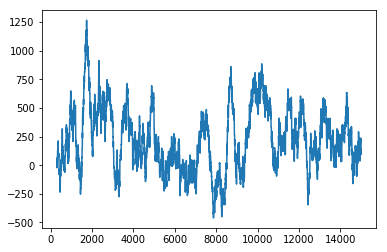

In [89]:
plt.plot(pd.rolling_mean(pd.Series(r_list), 300))

/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=300,center=False).mean()
  """Entry point for launching an IPython kernel.


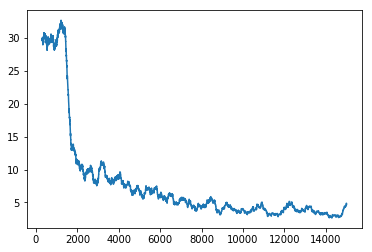

In [90]:
plt.plot(pd.rolling_mean(pd.Series(j_list), 300))

/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=300,center=False).mean()
  """Entry point for launching an IPython kernel.


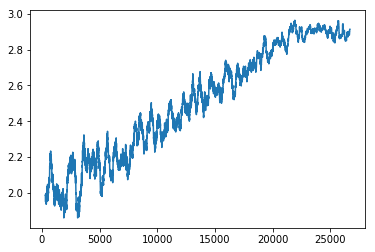

In [42]:
plt.plot(pd.rolling_mean(pd.Series(action_list), 300))

In [75]:
len(train_batch[0])

7

In [132]:
%time
with tf.Session() as sess:
    sess.run(init)
    ckpt = tf.train.get_checkpoint_state(path)
    print(ckpt.model_checkpoint_path)
    saver.restore(sess, ckpt.model_checkpoint_path)
    action_num = sess.run(main_wp.predict, feed_dict={main_wp.scalar_input: [train_batch[3][0]],
                                                      main_wp.features_input: [train_batch[3][1]]})[0]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.3 µs
models/model_197000.ckpt
INFO:tensorflow:Restoring parameters from models/model_197000.ckpt


In [114]:
train_batch = my_buffer.sample(batch_size)

In [116]:
%time
with tf.Session() as sess:
    batch = train_batch[3]
    qs = []
    img = batch[0]
    features = batch[1]

    sess.run(init)
    ckpt = tf.train.get_checkpoint_state(path)
    print(ckpt.model_checkpoint_path)
    saver.restore(sess, ckpt.model_checkpoint_path) # 'models/model_197000.ckpt')
    
#     for x in np.linspace(-0.5, 1.5, 100):
#     for x in np.linspace(0, 10000, 100):
#     for x in np.linspace(0, 50, 51):
    for x in np.linspace(0, 20000, 100):
#         features[-1] = x
#         features[5] = x
#         features[-10] = x
        features[4] = x
        action_num = sess.run(main_wp.Q_out, feed_dict={main_wp.scalar_input: [img],
                                                      main_wp.features_input: [features]})[0]
        qs.append(action_num)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.78 µs
models/model_88000.ckpt
INFO:tensorflow:Restoring parameters from models/model_88000.ckpt


In [117]:
import pandas as pd
%matplotlib inline

In [118]:
df = pd.DataFrame(np.vstack(qs), columns=['1', '2', '3', '4', '5'])

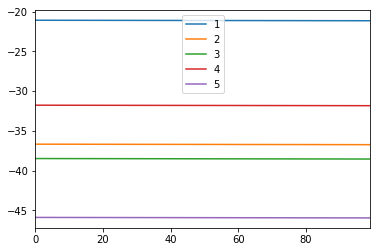

In [164]:
df.plot(df.index, ['1', '2', '3', '4', '5'])

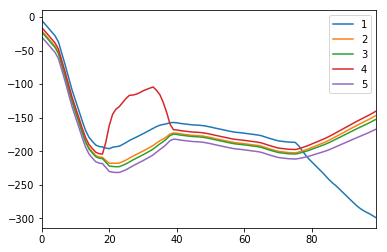

In [170]:
df.plot(df.index, ['1', '2', '3', '4', '5'])

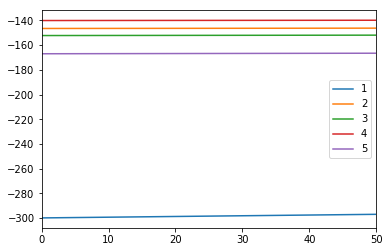

In [174]:
df.plot(df.index, ['1', '2', '3', '4', '5'])

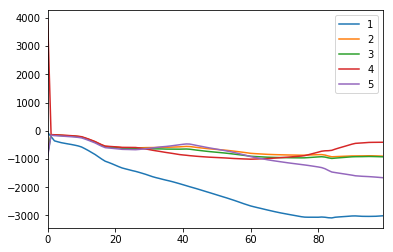

In [179]:
df.plot(df.index, ['1', '2', '3', '4', '5'])

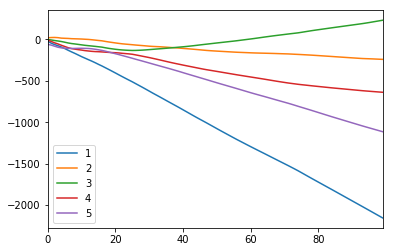

In [119]:
df.plot(df.index, ['1', '2', '3', '4', '5'])

In [166]:
features

[0,
 1,
 0,
 0,
 270,
 285,
 4,
 5,
 6,
 6,
 5,
 225,
 225,
 225,
 225,
 225,
 7785,
 3810,
 225,
 1.5]

In [118]:
kernel = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'conv2d/kernel')
d = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dense/kernel')

In [119]:
kernel2 = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'conv2d_3/kernel')

In [120]:
k = kernel[0]
# k2 = kernel2[0]
d = d[0]

In [121]:
with tf.Session() as sess:
    sess.run(init)
    ckpt = tf.train.get_checkpoint_state(path)
    saver.restore(sess, ckpt.model_checkpoint_path)
    c1 = k.eval(session=sess)
    d1 = d.eval(session=sess)
#     c2 = k2.eval(session=sess)
    

INFO:tensorflow:Restoring parameters from models/model_197000.ckpt


In [122]:
c1.shape, c2.shape

NameError: name 'c2' is not defined

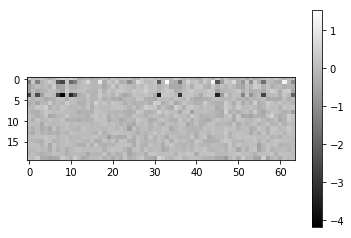

In [123]:
plt.imshow(d1)
plt.gray()
plt.colorbar()

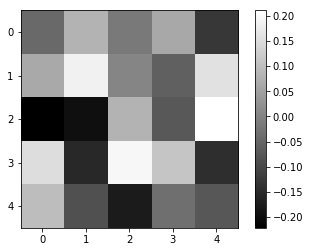

In [128]:
plt.imshow(c1[:, :, 7, 1])
plt.gray()
plt.colorbar()

In [129]:
plt.imshow(c2[:, :, 7, 10])
plt.gray()
plt.colorbar()

NameError: name 'c2' is not defined

## Fish bot

## Random bot

In [84]:
import random as rand

class RandomPlayer(BasePokerPlayer):

  def __init__(self):
    self.fold_ratio, self.call_ratio, raise_ratio = 1.0/5, 3.0/5, 1.0/5

  def set_action_ratio(self, fold_ratio, call_ratio, raise_ratio):
    ratio = [fold_ratio, call_ratio, raise_ratio]
    scaled_ratio = [ 1.0 * num / sum(ratio) for num in ratio]
    self.fold_ratio, self.call_ratio, self.raise_ratio = scaled_ratio

  def declare_action(self, valid_actions, hole_card, round_state):
    global imgs
    imgs.append(img_from_state(hole_card, round_state))
    choice = self.__choice_action(valid_actions)
    action = choice["action"]
    amount = choice["amount"]
    if action == "raise":
      amount = rand.randrange(amount["min"], max(amount["min"], amount["max"]) + 1)
    return action, amount

  def __choice_action(self, valid_actions):
    r = rand.random()
    if r <= self.fold_ratio:
      return valid_actions[0]
    elif r <= self.call_ratio:
      return valid_actions[1]
    else:
      return valid_actions[2]


  def receive_game_start_message(self, game_info):
    pass

  def receive_round_start_message(self, round_count, hole_card, seats):
    pass

  def receive_street_start_message(self, street, round_state):
    pass

  def receive_game_update_message(self, new_action, round_state):
    pass

  def receive_round_result_message(self, winners, hand_info, round_state):
    pass

---

## Training

In [114]:
import warnings

In [171]:
%%time
# warnings.filterwarnings('ignore')
from contextlib import redirect_stderr
with open('/dev/null', 'w') as stderr, redirect_stderr(stderr):
    iterations = 5000

    w1 = WinnerPlayer()
    w2 = WinnerPlayer()
    w3 = WinnerPlayer()

    for i in range(iterations):
        if i % 500 == 0:
            print(i)
        w1.clear_experience()
        w2.clear_experience()
        w3.clear_experience()

        config = setup_config(max_round=50, initial_stack=1500, small_blind_amount=15) 
        config.register_player(name="w1", algorithm=w1)
        config.register_player(name="w2", algorithm=w2)
        config.register_player(name="w3", algorithm=w3)

        config.register_player(name="r4", algorithm=RandomPlayer())
        config.register_player(name="r5", algorithm=RandomPlayer())
        config.register_player(name="r6", algorithm=RandomPlayer())

        config.register_player(name="f7", algorithm=FishPlayer())
        config.register_player(name="f8", algorithm=FishPlayer())
        config.register_player(name="f9", algorithm=FishPlayer())

        game_result = start_poker(config, verbose=0)
    #     print('epoch {}, fit on {} samples, reward {}, q {}'.format(i, len(targets), np.mean(rewards[-10:]),
    #                                                                                          np.mean(qs[-10:])))
        w1.fit()
        w2.fit()
        w3.fit()

0
500
1000
1500
2000
2500
3000
3500
4000
4500
CPU times: user 34min 58s, sys: 1min 36s, total: 36min 34s
Wall time: 27min 18s


## Testing

In [87]:
imgs = []

In [88]:
config = setup_config(max_round=2, initial_stack=1500, small_blind_amount=15)
# w = WinnerPlayer(True)
# w2.debug = True
# config.register_player(name="w1", algorithm=w1)
config.register_player(name="f1", algorithm=FishPlayer())
config.register_player(name="r2", algorithm=RandomPlayer())
# config.register_player(name="f3", algorithm=FishPlayer())
# config.register_player(name="f4", algorithm=FishPlayer())
# config.register_player(name="f5", algorithm=FishPlayer())
# config.register_player(name="f6", algorithm=FishPlayer())
# config.register_player(name="f7", algorithm=FishPlayer())
# config.register_player(name="f8", algorithm=FishPlayer())
# config.register_player(name="f9", algorithm=FishPlayer())

game_result = start_poker(config, verbose=1)

{'round_count': 1, 'small_blind_amount': 15, 'street': 0, 'next_player': 1, 'table': <pypokerengine.engine.table.Table object at 0x7faa59980358>}
Started the round 1
Street "preflop" started. (community card = [])
"r2" declared "raise:68"
{'round_count': 1, 'small_blind_amount': 15, 'street': 1, 'next_player': 1, 'table': <pypokerengine.engine.table.Table object at 0x7faa599808d0>}
"f1" declared "call:68"
Street "flop" started. (community card = ['S7', 'C6', 'CT'])
"r2" declared "fold:0"
"['f1']" won the round 1 (stack = {'f1': 1568, 'r2': 1432})
{'round_count': 2, 'small_blind_amount': 15, 'street': 0, 'next_player': 0, 'table': <pypokerengine.engine.table.Table object at 0x7faa599f0898>}
Started the round 2
Street "preflop" started. (community card = [])
"f1" declared "call:30"
"r2" declared "fold:0"
"['f1']" won the round 2 (stack = {'f1': 1598, 'r2': 1402})


Exception ignored in: <bound method GameSummarizer.__del__ of <pypokerengine.engine.dealer.GameSummarizer object at 0x7faa59970940>>
Traceback (most recent call last):
  File "/home/digitman/python_projects/holdem-challenge/pypokerengine/engine/dealer.py", line 297, in __del__
    self.summary_file.close()
AttributeError: 'NoneType' object has no attribute 'close'


In [99]:
imgs[0].sum()

4.0

In [104]:
imgs[0].sum(axis=1)

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]])

In [116]:
plt.imshow(imgs[3][7,:,:])

IndexError: list index out of range

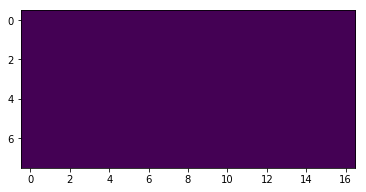

In [95]:
plt.imshow(imgs[0][:,:,6])

### State check

In [ ]:
# self.features.extend([bank, stack, dealer_btn, small_blind_pos, big_blind_pos, next_player], round_count)

In [138]:
w.experience[6][0][0].sum()

14.0

In [122]:
len(w.experience)

199

In [135]:
w.experience[4][0][1]

[0, 1, 0, 0, 5337, 877, 1, 2, 3, 0, 2, 1, 1, 1, 1, 1, 1, 1, 7279]

### Model analysis

In [155]:
w1.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
inp1 (InputLayer)                (None, 8, 17, 17)     0                                            
____________________________________________________________________________________________________
conv2d_97 (Conv2D)               (None, 32, 7, 7)      6432        inp1[0][0]                       
____________________________________________________________________________________________________
conv2d_98 (Conv2D)               (None, 32, 5, 5)      9248        conv2d_97[0][0]                  
____________________________________________________________________________________________________
inp2 (InputLayer)                (None, 19)            0                                            
___________________________________________________________________________________________

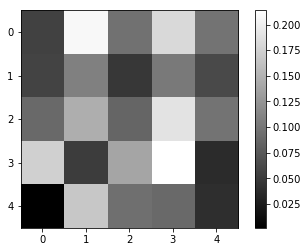

In [175]:
plt.imshow(w1.model.layers[1].get_weights()[0][:, :, 7, 2])
plt.gray()
plt.colorbar()

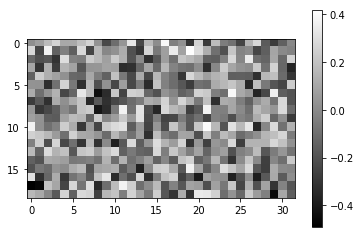

In [177]:
plt.imshow(w1.model.layers[5].get_weights()[0])
plt.gray()
plt.colorbar()

## Training analysis

In [178]:
import pandas as pd

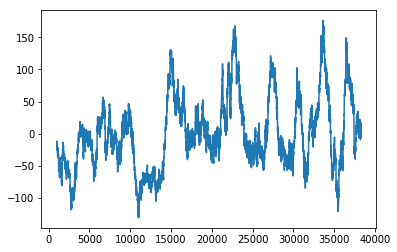

In [183]:
# plt.plot(w1.rewards)
plt.plot(pd.rolling_mean(pd.Series(w1.rewards), 1000))

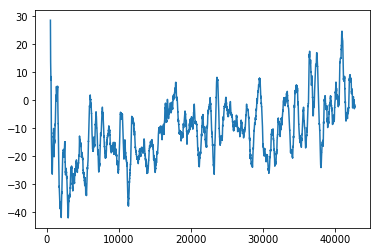

In [184]:
# plt.plot(w1.qs)
plt.plot(pd.rolling_mean(pd.Series(w1.qs), 500))

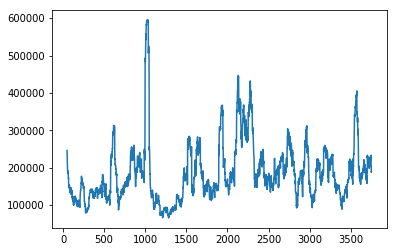

In [186]:
# plt.plot(w1.losses)
plt.plot(pd.rolling_mean(pd.Series(w1.losses), 50))
# plt.ylim(0, np.max(losses) // 2)

### Скорость инференса

In [187]:
%%time
p = w1.model.predict_on_batch([np.expand_dims(w1.experience[0][0][0], 0), np.expand_dims(w1.experience[0][0][1], 0)])

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.6 ms


## Против человека в консоле

In [156]:
import pypokerengine.utils.visualize_utils as U
from pypokerengine.players import BasePokerPlayer

class ConsolePlayer(BasePokerPlayer):

  def __init__(self, input_receiver=None):
    self.input_receiver = input_receiver if input_receiver else self.__gen_raw_input_wrapper()

  def declare_action(self, valid_actions, hole_card, round_state):
    print(U.visualize_declare_action(valid_actions, hole_card, round_state, self.uuid))
    action, amount = self.__receive_action_from_console(valid_actions)
    return action, amount

  def receive_game_start_message(self, game_info):
    print(U.visualize_game_start(game_info, self.uuid))
    self.__wait_until_input()

  def receive_round_start_message(self, round_count, hole_card, seats):
    print(U.visualize_round_start(round_count, hole_card, seats, self.uuid))
    self.__wait_until_input()

  def receive_street_start_message(self, street, round_state):
    print(U.visualize_street_start(street, round_state, self.uuid))
    self.__wait_until_input()

  def receive_game_update_message(self, new_action, round_state):
    print(U.visualize_game_update(new_action, round_state, self.uuid))
    self.__wait_until_input()

  def receive_round_result_message(self, winners, hand_info, round_state):
    print(U.visualize_round_result(winners, hand_info, round_state, self.uuid))
    self.__wait_until_input()

  def __wait_until_input(self):
    input("Enter some key to continue ...")

  def __gen_raw_input_wrapper(self):
    return lambda msg: input(msg)

  def __receive_action_from_console(self, valid_actions):
    flg = self.input_receiver('Enter f(fold), c(call), r(raise).\n >> ')
    if flg in self.__gen_valid_flg(valid_actions):
      if flg == 'f':
        return valid_actions[0]['action'], valid_actions[0]['amount']
      elif flg == 'c':
        return valid_actions[1]['action'], valid_actions[1]['amount']
      elif flg == 'r':
        valid_amounts = valid_actions[2]['amount']
        raise_amount = self.__receive_raise_amount_from_console(valid_amounts['min'], valid_amounts['max'])
        return valid_actions[2]['action'], raise_amount
    else:
      return self.__receive_action_from_console(valid_actions)

  def __gen_valid_flg(self, valid_actions):
    flgs = ['f', 'c']
    is_raise_possible = valid_actions[2]['amount']['min'] != -1
    if is_raise_possible:
      flgs.append('r')
    return flgs

  def __receive_raise_amount_from_console(self, min_amount, max_amount):
    raw_amount = self.input_receiver("valid raise range = [%d, %d]" % (min_amount, max_amount))
    try:
      amount = int(raw_amount)
      if min_amount <= amount and amount <= max_amount:
        return amount
      else:
        print("Invalid raise amount %d. Try again.")
        return self.__receive_raise_amount_from_console(min_amount, max_amount)
    except:
      print("Invalid input received. Try again.")
      return self.__receive_raise_amount_from_console(min_amount, max_amount)

In [157]:
from pypokerengine.api.game import setup_config, start_poker

config = setup_config(max_round=10, initial_stack=100, small_blind_amount=5)
config.register_player(name="w", algorithm=w)
config.register_player(name="human_player", algorithm=ConsolePlayer())
game_result = start_poker(config, verbose=0)

-- Game start (UUID = qaeykkbzmnbbfhmlchbjcu) --
-- rule --
  - 2 players game
  - 10 round
  - start stack = 100
  -        ante = 0
  - small blind = 5
Enter some key to continue ...
(['Hole:', ['H2', 'CQ']],)
(['Start stack:', 90],)
-- Round 1 start (UUID = qaeykkbzmnbbfhmlchbjcu) --
-- hole card --
  - ['S9', 'DK']
-- players information --
  - 0 : w (hzwnwxqpjkanfffllaqluq) => state : participating, stack : 90
  - 1 : human_player (qaeykkbzmnbbfhmlchbjcu) => state : participating, stack : 95
Enter some key to continue ...
-- New street start (UUID = qaeykkbzmnbbfhmlchbjcu) --
-- street --
  - preflop
Enter some key to continue ...
-- Declare your action (UUID = qaeykkbzmnbbfhmlchbjcu) --
-- valid actions --
  - fold
  - call: 10
  - raise: [15, 100]
-- hole card --
  - ['S9', 'DK']
-- round state --
  - dealer btn : w
  - street : preflop
  - community card : []
  - pot : main = 15, side = []
  - players information
    - 0 : w (hzwnwxqpjkanfffllaqluq) => state : participating, st

ValueError: Error when checking : expected inp2 to have shape (None, 19) but got array with shape (1, 12)

## Оценка силы руки

In [158]:
from pypokerengine.utils.card_utils import gen_cards, estimate_hole_card_win_rate
hole_card = gen_cards(['H4', 'D7'])
community_card = gen_cards(['D3', 'C5', 'C6'])

In [159]:
%%time
estimate_hole_card_win_rate(nb_simulation=500, nb_player=9, hole_card=hole_card, community_card=community_card)

CPU times: user 764 ms, sys: 0 ns, total: 764 ms
Wall time: 761 ms


0.588

In [162]:
%%time
means = []
stds = []

x = list(range(10, 1110, 100))

for i in x:
    res = [estimate_hole_card_win_rate(nb_simulation=i, nb_player=9, hole_card=hole_card,
                                       community_card=community_card) for j in range(10)]
    means.append(np.mean(res))
    stds.append(np.std(res))

CPU times: user 1min 5s, sys: 0 ns, total: 1min 5s
Wall time: 1min 5s


<Container object of 3 artists>

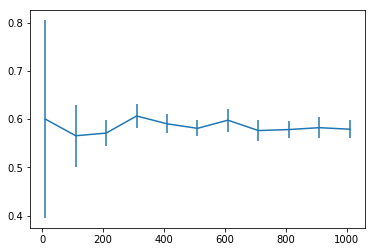

In [163]:
plt.errorbar(x, means, stds)

In [164]:
%%time
means = []
stds = []

x = list(range(2, 10))

for i in x:
    res = [estimate_hole_card_win_rate(nb_simulation=200, nb_player=i, hole_card=hole_card,
                                       community_card=community_card) for j in range(10)]
    means.append(np.mean(res))
    stds.append(np.std(res))

CPU times: user 12.1 s, sys: 0 ns, total: 12.1 s
Wall time: 12.1 s


<Container object of 3 artists>

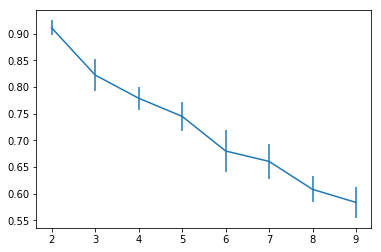

In [165]:
plt.errorbar(x, means, stds)

In [113]:
_montecarlo_simulation??
# estimate_hole_card_win_rate??